Include a coupled bending-torsion into a 3D Euler-Bernoulli Beam

coordinate system: x -> longitudinal axis, y -> perpendicular

The coupling is achived by introducing coupling terms into the stiffness matrix.
Furthermore Material parameters are adjusted in order to reach a specified Eigenbehavior. 
The procedure can be seperated into 3 Steps:
   1. Material parameters are optimized such that target Eigenfrequencies are reached. 
   2. The coupling paramters are optimized such the the eigen deformations are reached.
   3. The Material parameters are readjusted such that the Eigenfreuqencies are reached again

For the coupling optimization a target is required. Two different targets are implemented:
   - target based on a reference Eigenvalue analysis of a coupled model including the Eigenfrequencies and eigen deformations 
   - target based on the assumption that in a coupled case the bedning deformation is reduced by some factor whereas the torsional
     deformation increases in the same mode

In [2]:
import matplotlib.pyplot as plt
import copy
from os.path import join as os_join

from source.model import BeamModel
from source.optimizations import Optimizations
from source.postprocess import Postprocess
from source.utilities import utilities as utils
from plot_settings import plot_settings
from source.dynamic_analysis import DynamicAnalysis
from inputs import model_parameters

Setting the model geometric, material, element parameters. (set model = 'custom')
Alternatively set model = 'A' or 'B'. They correspond to geometrical properties of the respective CAARC standard tall building.

Important for the torsion coupling are:
    I_param: a parametric material parameter that couples torsion with bending. This should be initially in the scale of Iy, Iz. 
             -> check what happens if this is changed
    'initial_params_yg': 


In [3]:
model = 'B' #'A', 'B' 'custom

if model == 'custom':
    parameters = {  
                'dimension': '3D',
                'n_elements': 10,
                'nodes_per_elem': 2,
                'lx_total_beam': 180,
                'material_density': 100, 
                'E_Modul': 286100000.0,
                'nu': 0.1, 
                'damping_coeff': 0.025,
                'cross_section_area': 30*45,
                'B':45,
                'D':30,
                'Iy': 227812.5,
                'Iz': 101250.0,
                'I_param':10000.0, 
                'It': 50000.0,
                'modes_to_consider': 15,
                'static_load_magnitude': -20.0,
                'dynamic_load_file': os_join(*["inputs","forces","dynamic_force_11_nodes.npy"]),
                'inital_params_yg': [1.0,1.0,1.0],
                'params_k_ya': [0,0],#omega: stiffness coupling y - a omega1: y -g
                'params_m_ya': [0.0,0.0,0.0],#omega: stiffness coupling, psi1, psi2: mass y-a, psi3: mass g-a                
                'eigen_freqs_tar':[0.2591, 0.3249, 1.3555], 
             }
else:
    parameters = model_parameters.parameters[model]

analysis_parameters = model_parameters.dynamic_analysis_parameters

In [4]:
postprocess_parameters = {
                  'show_plots':True,
                  'savefig':False,
                  'optimization_procedure':{'intermediate_eigenmodes':True, 'objective_function':False},
                  'eigenmodes':{'do':False, 'n_modes':3, 'add_max_val':False, 'max_norm':False, 'rad_scale':True, 'caarc_A_only':False}, # with ajdusted frequencies
                  'static_analysis':{'do':False, 'load_directions':['y','a']},
                  'dynamic_analysis':{'do':True, 'time_hist':True, 'comp_stats':True,'comp_energy':True, 'normed':False,
                                                 'response':'total','response_type':'acceleration', 'node_id':10,'save_object':False, #response: use 'total' for acceleration total
                                                 'stats':['mean', 'std','max_est'],'unit':'MN', 'save_suffix':'_couple_uncouple_quer_1'},
                 }

Create a beam model and Tune material parameters to match the target eigenfrequencies

In [5]:
intermediate_results = {'eigenfrequencies':[],
                         'eigenmodes':[],
                         'dynamic_analysis':[],
                         'static_analysis':[]}

# CREATE AN INITAL BEAM
# with initial frequency adjustments
beam = BeamModel(parameters, coupled=False, optimize_frequencies_init=True, use_translate_matrix=False)

# collect initial results
intermediate_results['eigenfrequencies'].append(beam.eigenfrequencies)
intermediate_results['eigenmodes'].append(beam.eigenmodes)

dynamic_analysis_init = DynamicAnalysis(beam, parameters = analysis_parameters)
dynamic_analysis_init.solve()
intermediate_results['dynamic_analysis'].append(dynamic_analysis_init)

beam.static_analysis_solve(apply_mean_dynamic=True, directions='all')
intermediate_results['static_analysis'].append(beam.static_deformation)


C:\Users\Johannes\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
c:\Users\Johannes\Documents\TUM\5.MasterThesis\CoupledBeams\3DBeam\source\model.py:203: RuntimeWarning: invalid value encountered in sqrt
  self.eig_values = np.sqrt(np.real(self.eigen_values_raw))
c:\Users\Johannes\Documents\TUM\5.MasterThesis\CoupledBeams\3DBeam\source\model.py:206: RuntimeWarning: divide by zero encountered in true_divide
  self.eig_periods = 1 / self.eigenfrequencies
c:\Users\Johannes\Documents\TUM\5.MasterThesis\CoupledBeams\3DBeam\source\model.py:341: RuntimeWarning: divide by zero encountered in double_scalars
  [[1 / self.eig_values[self.eig_freqs_sorted_indices[mode_i]],


Setting parameters for the optimization of the coupling (if not a CAARC model is taken).

Explenation of some settings:
- eigen_freqs_target: the target frequencies of the first three modes
- coupling_target:
    - 'realisitc': takes eigen results from full 3D FE simulation of exccentirc building (ARiedls work) (with CAARC model 'B' only)
    - 'semi_realistic': uses values from the optimization_params: 'ratio_a_y_tar' at the tip, 'factor_y'; a twist displacement is amplified -> original shape is taken
    - 'custom': 'factor_y' times the initial lateral displacement & 'ratio_a_y_tar' at the tip; alpha twist is assumed linear

In [6]:
if model == 'custom':
    # # AVAILABLE/PROPOSED OPTIMIZATION OPTIONS AND INPUT PARAMETER SETTINGS
    opt_methods = ['Nelder-Mead', 'SLSQP', 'Powell', 'BFGS', 'L-BFGS-B','TNC', 'CG']

    optimization_variables = ['kya','kga','both']

    weights = [[0.33,0.33,.33],[0.5,0.5,0.],[.4,.4,.2],[.45,.45,.1],[.8,.1,.1],[.1,.8,.1],[.2,.4,.4],[0.1,0.1,0.8]]

    optimization_parameters ={
        'eigen_freqs_tar':[0.2591, 0.3249, 1.3555],
        'coupling_target':'semi_realistic', # custom, semi_realistic, realistic
        'ratio_a_y_tar': 0.00372,
        'factor_y':0.9,
        'readjust':{'sway_z':True,'sway_y':False,'torsion':False},
        'consider_mode':0,
        'var_to_optimize' :optimization_variables[2],#'ya'#'ga' both
        'include_mass':False,
        'method': opt_methods[1],
        'init_guess':[0.,10.,0],
        'bounds':((0.01, 100),(0.01, 100),(.0000001, 100)), 
        'weights':weights[1],
        'save_optimized_parameters':False
        }

else:
    optimization_parameters = model_parameters.optimization_parameters[model]

Do the Optimizations by only considering the coupling parameter.

In [7]:
coupling_opt = Optimizations(beam, optimization_parameters)

var_to_optimize = optimization_parameters['var_to_optimize']
if var_to_optimize != 'both':
   # optimize onyl one stiffness variable
   coupling_opt.eigen_ya_stiffness_opt(which = var_to_optimize)   
else:
   # optimizing both stiffness variabels
   coupling_opt.eigen_vectorial_ya_opt(target_to_use=optimization_parameters['coupling_target'])

intermediate_results['coupling_optimization'] = coupling_opt

coupled_beam = beam.update_optimized_parameters(coupling_opt.optimized_design_params)
intermediate_results['eigenfrequencies'].append(coupled_beam.eigenfrequencies)
intermediate_results['eigenmodes'].append(coupled_beam.eigenmodes)


not optimizing the mass entries, thus...
  ...dropping the 3rd bound given
  ...dropping the 3rd initial guess given

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02569816618806063
            Iterations: 7
            Function evaluations: 21
            Gradient evaluations: 7

optimized parameters:
  k_ya: 0.01 absolute: 9811385.0
  k_ga: 6.27241 absolute: -664642942671.0

updating:
     Iz from 101250 to 63712.0 increasing by: -37.07 %
     Iy from 227812 to 83680.0 increasing by: -63.27 %
     It from 50000 to 127652.0 increasing by: 155.3 %
     Ip from 2005541.0 to 2005541.0 increasing by: -0.0 %
     params_k_ya from [0, 0] to [0.01       6.27240804] (k_ya, kga)

updated optimized parameters


Proably the eigenfrequencies must be readjusted.

In [8]:
opt_params_readjust = {'init_guess':[10,10], 'bounds':(0.001,100),'weights':None,'consider_mode':None,'method':None}
print ('\nOptimization of frequency after coupling...')

if optimization_parameters['readjust']['sway_z']: 
   freq_opt = Optimizations(model=coupled_beam, optimization_parameters=opt_params_readjust)
   print ('   ...readjusting stiffness for sway_z')
   freq_opt.adjust_sway_z_stiffness_for_target_eigenfreq(parameters['eigen_freqs_tar'][0], 
                                                         target_mode = 0,
                                                         print_to_console=True)
if optimization_parameters['readjust']['sway_y']: 
   freq_opt_y = Optimizations(model=coupled_beam, optimization_parameters=opt_params_readjust)
   print ('   ...readjusting stiffness for sway_y')
   freq_opt_y.adjust_sway_y_stiffness_for_target_eigenfreq(parameters['eigen_freqs_tar'][1], 
                                                         target_mode = 1,
                                                         print_to_console=True)

if optimization_parameters['readjust']['torsion']:
   freq_opt_torsion = Optimizations(model=coupled_beam, optimization_parameters=opt_params_readjust)                                                     
   print ('   ...readjusting stiffness for sway_torsion')
   freq_opt.adjust_torsional_stiffness_for_target_eigenfreq(parameters['eigen_freqs_tar'][2], 
                                                            target_mode = 2,
                                                            print_to_console=True)

intermediate_results['eigenfrequencies'].append(coupled_beam.eigenfrequencies)
intermediate_results['eigenmodes'].append(coupled_beam.eigenmodes)

dynamic_analysis_coupled = DynamicAnalysis(coupled_beam, parameters = analysis_parameters)
dynamic_analysis_coupled.solve()
intermediate_results['dynamic_analysis'].append(dynamic_analysis_coupled)

coupled_beam.static_analysis_solve(apply_mean_dynamic=True, directions='all')
intermediate_results['static_analysis'].append(coupled_beam.static_deformation)


Optimization of frequency after coupling...
   ...readjusting stiffness for sway_z
  INITIAL iz: 63712.5284086382, 63712.5284086382, 63712.5284086382, 63712.5284086382, 63712.5284086382, 63712.5284086382, 63712.5284086382, 63712.5284086382, 63712.5284086382, 63712.5284086382

  OPTIMIZED iz:  83679.5617819035, 83679.5617819035, 83679.5617819035, 83679.5617819035, 83679.5617819035, 83679.5617819035, 83679.5617819035, 83679.5617819035, 83679.5617819035, 83679.5617819035

  FACTOR:  1.313392575557528
  Final Func: 0.024664720672798207



Postprocess the collected results

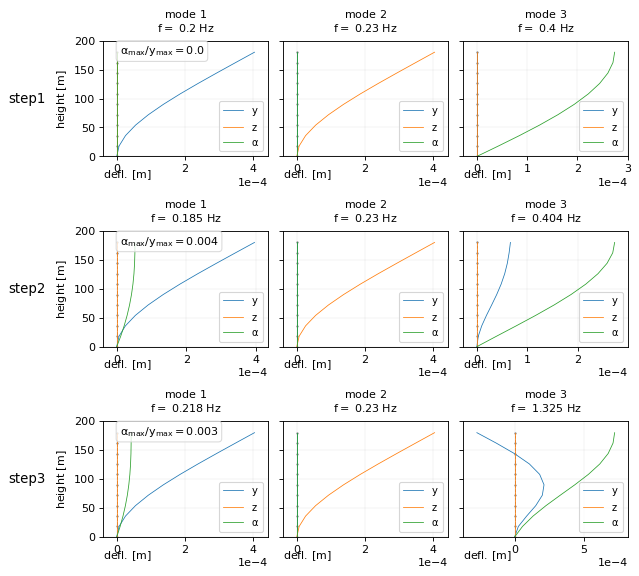

C:\Users\Johannes\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


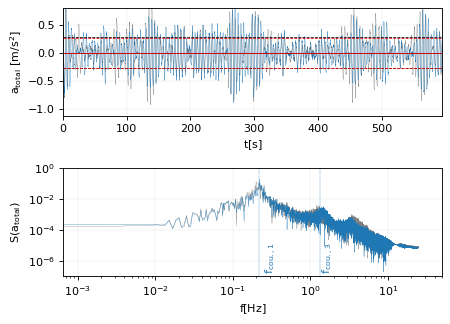

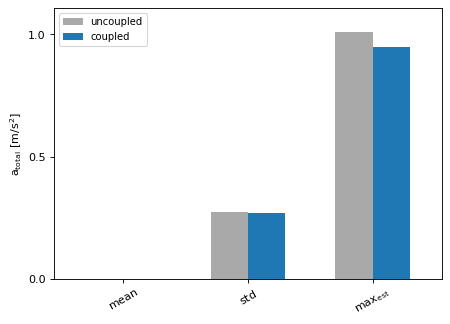


Calculate modal kinetic energy...

  TOTAL ENERGY sum over time: 1407132.0

Calculate modal kinetic energy...

  TOTAL ENERGY sum over time: 951594.0


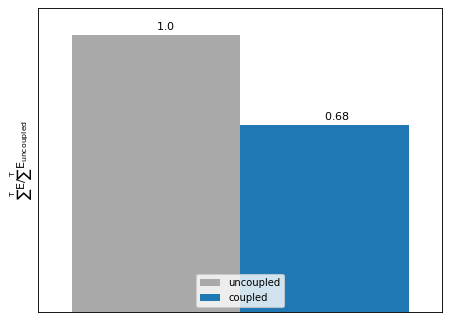

  coupled deformation y is 0.84 of uncoupled.
  coupled deformation \alpha is -277 of uncoupled.
  w_max ist beam:      0.3351724561599433


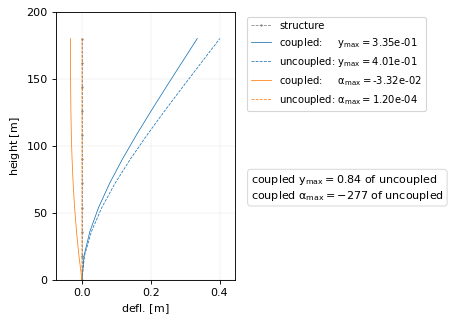

In [10]:
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]

width = utils.cm2inch(14)
height = utils.cm2inch(10)

latex = False
savefig = False

plot_params = plot_settings.get_params(width =width, height=height, usetex=latex, minor_ticks=False)

plt.rcParams.update(plot_params)

postprocess = Postprocess(postprocess_parameters, intermediate_results, beam, caarc_model=model)